In [1]:
# wine dataset으로 레드/화이트 와인 분류 모델을 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [17]:
from tabnanny import verbose
from lief import Binary
from matplotlib import units
from scipy import optimize
from streamlit import metric
from xgboost import train


wdf = pd.read_csv('https://raw.githubusercontent.com/pykwon/python/refs/heads/master/testdata_utf8/wine.csv',header=None)
print(wdf.head(3))
# print(wdf.info())
print(wdf.iloc[:, 12].unique())     # [1 0] red/white
print(len(wdf[wdf.iloc[:, 12] == 0]))   # 4898
print(len(wdf[wdf.iloc[:, 12] == 1]))   # 1599

dataset = wdf.values
x = dataset[:, 0:12]
y = dataset[:, -1]

np.set_printoptions(suppress=True)
print(x[:3])
print(y[:3])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=12)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train[:3])
print(y_train[:3])

# 모델 생성
model = Sequential()
model.add(Input(shape=(12,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))    # 과적합 방지용
model.add(BatchNormalization()) # 배치 정규화, 역전파시 기울기 소실 또는 폭주 방지, cnn 등에서 특히 효과적
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
print(model.summary())

model.compile(optimizer='adam', loss="binary_crossentropy", metrics = ['accuracy'])
# fit() 전에 model score  확인
loss, acc = model.evaluate(x_train, y_train, verbose=0)
print('훈련 전 모델 정확도: {:5.2f}%.format(100 * acc)')


    0     1     2    3      4     5     6       7     8     9    10  11  12
0  7.4  0.70  0.00  1.9  0.076  11.0  34.0  0.9978  3.51  0.56  9.4   5   1
1  7.8  0.88  0.00  2.6  0.098  25.0  67.0  0.9968  3.20  0.68  9.8   5   1
2  7.8  0.76  0.04  2.3  0.092  15.0  54.0  0.9970  3.26  0.65  9.8   5   1
[1 0]
4898
1599
[[ 7.4     0.7     0.      1.9     0.076  11.     34.      0.9978  3.51
   0.56    9.4     5.    ]
 [ 7.8     0.88    0.      2.6     0.098  25.     67.      0.9968  3.2
   0.68    9.8     5.    ]
 [ 7.8     0.76    0.04    2.3     0.092  15.     54.      0.997   3.26
   0.65    9.8     5.    ]]
[1. 1. 1.]
(4547, 12) (1950, 12) (4547,) (1950,)
[[  5.9       0.3       0.3       2.        0.03     38.      142.
    0.98892   3.41      0.41     12.9       7.     ]
 [  6.7       0.31      0.18      7.7       0.043    57.      200.
    0.99566   3.17      0.44      9.4       6.     ]
 [  8.9       0.34      0.32      1.3       0.041    12.      188.
    0.9953    3.17      0.4

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 64 (256.00 B)

None
훈련 전 모델 정확도: {:5.2f}%.format(100 * acc)


In [23]:
# 모델 저장 설정
from gc import callbacks
from libmambapy import History
from lightgbm import early_stopping
from sympy import evaluate


MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = 'model/{epoch:02d}_{val_loss:.4f}.keras'

# 모델 학습과정에서 특정 기준에 따라 자동으로 모델을 저장하는 callback
chkpoint = ModelCheckpoint(filepath=modelpath, monitor='val_loss', mode='auto', save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train, validation_split=0.2, epochs=1000, batch_size=64, callbacks = [early_stop, chkpoint], verbose=2)

loss, acc = model.evaluate(x_test, y_test, batch_size=64, verbose=0)
print('훈련 후 모델 정확도: {:.2f}%'.format(100 * acc))

Epoch 1/1000
57/57 - 0s - 4ms/step - accuracy: 0.9244 - loss: 0.3170 - val_accuracy: 0.9275 - val_loss: 0.2093
Epoch 2/1000
57/57 - 0s - 3ms/step - accuracy: 0.9236 - loss: 0.2306 - val_accuracy: 0.9363 - val_loss: 0.1865
Epoch 3/1000
57/57 - 0s - 3ms/step - accuracy: 0.9258 - loss: 0.2166 - val_accuracy: 0.9396 - val_loss: 0.1751
Epoch 4/1000
57/57 - 0s - 3ms/step - accuracy: 0.9293 - loss: 0.2012 - val_accuracy: 0.9385 - val_loss: 0.1717
Epoch 5/1000
57/57 - 0s - 3ms/step - accuracy: 0.9351 - loss: 0.1833 - val_accuracy: 0.9451 - val_loss: 0.1734
Epoch 6/1000
57/57 - 0s - 3ms/step - accuracy: 0.9359 - loss: 0.1799 - val_accuracy: 0.9495 - val_loss: 0.1586
Epoch 7/1000
57/57 - 0s - 3ms/step - accuracy: 0.9359 - loss: 0.1764 - val_accuracy: 0.9505 - val_loss: 0.1327
Epoch 8/1000
57/57 - 0s - 3ms/step - accuracy: 0.9423 - loss: 0.1670 - val_accuracy: 0.9527 - val_loss: 0.1297
Epoch 9/1000
57/57 - 0s - 3ms/step - accuracy: 0.9370 - loss: 0.1629 - val_accuracy: 0.9549 - val_loss: 0.1295
E

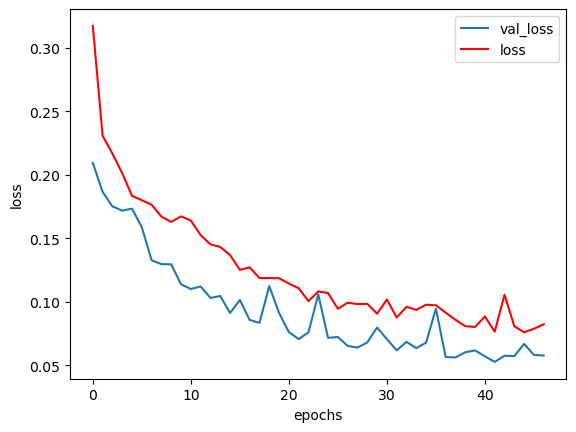

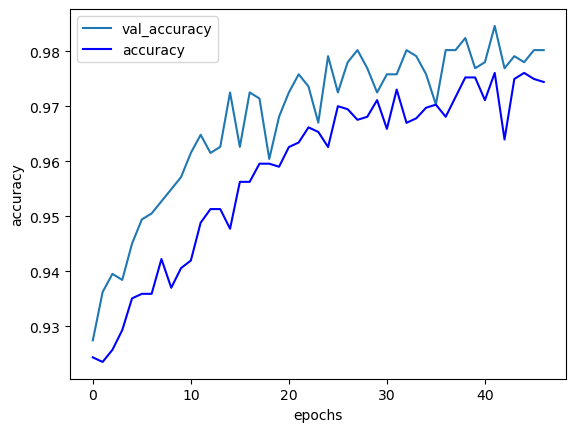

In [24]:
# 시각화
epoch_len = np.arange(len(history.epoch))

plt.plot(epoch_len, history.history['val_loss'], label='val_loss')
plt.plot(epoch_len, history.history['loss'], label='loss', c='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

plt.plot(epoch_len, history.history['val_accuracy'], label='val_accuracy')
plt.plot(epoch_len, history.history['accuracy'], label='accuracy', c='blue')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

In [27]:
# best 모델로 예측
from tensorflow.keras.models import load_model
model = load_model(MODEL_DIR + "42_0.0528.keras")

new_data = x_test[:5, :]
print(new_data)
pred = model.predict(new_data)
print('예측 결과: ', np.where(pred >= 0.5, 1, 0 ).ravel())

[[  7.2       0.15      0.39      1.8       0.043    21.      159.
    0.9948    3.52      0.47     10.        5.     ]
 [  6.9       0.3       0.29      1.3       0.053    24.      189.
    0.99362   3.29      0.54      9.9       4.     ]
 [  7.6       0.27      0.25     13.9       0.05     45.      199.
    0.9984    3.34      0.5       9.8       6.     ]
 [  7.9       0.22      0.38      8.        0.043    46.      152.
    0.9934    3.12      0.32     11.5       7.     ]
 [  9.5       0.59      0.44      2.3       0.071    21.       68.
    0.9992    3.46      0.63      9.5       5.     ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
예측 결과:  [0 0 0 0 1]
